<a href="https://colab.research.google.com/github/christmasv/Proyectos-de-ML/blob/Clasificacion-Aprendizaje-Supervisado/absentismo_modelo_rlogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regresión Logística: Absentismo Transformando la Cultura Laboral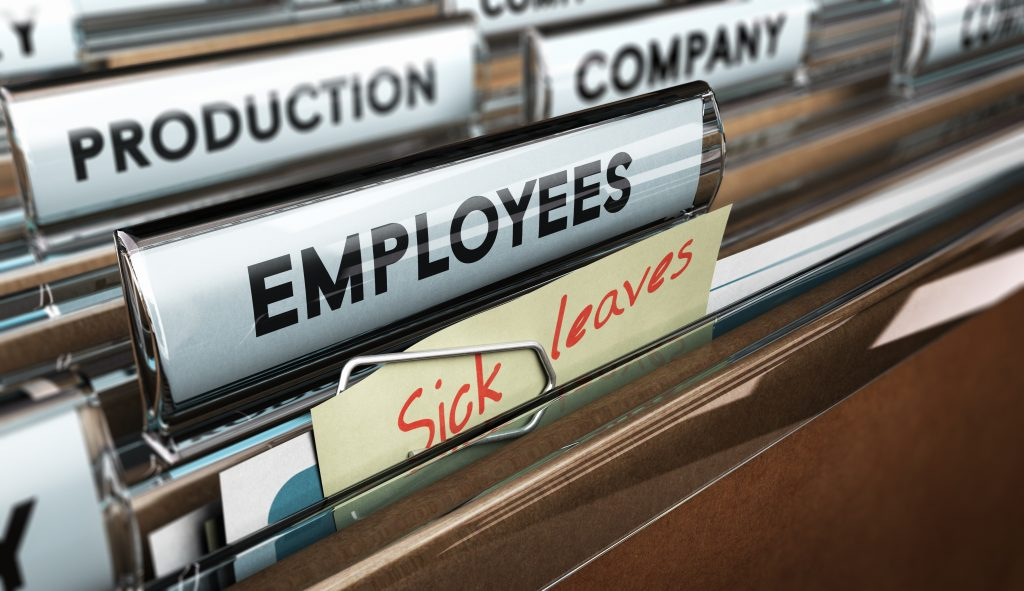**

# Regresión Logística | Absentismo Transformando la Cultura Laboral


 **Author** = [Christopher Soto](https://twitter.com/csv_81)

    @article{khrizoto,     
    Title        = {Regresión Logística | Absentismo Transformando la Cultura Laboral},
    Howpublished = {\url{https://khrizoto.wordpress.com/}},
    Year         = {2024}
    }

**Descripción:**

El absentismo laboral, la ausencia intencional o habitual de un empleado en el trabajo, puede impactar negativamente en la productividad y las finanzas de una empresa. Para abordar este problema, utilizo un conjunto de datos proporcionado por 365 Data Science, basado en un estudio sobre predicción del absentismo laboral. Mi objetivo es predecir el absentismo a partir de diversas variables. Las "horas" y la "fecha" son nuestras variables dependientes, mientras que otras columnas representan variables independientes que pueden ayudarnos a predecir futuras ausencias. A continuación, explicaremos cómo preprocesar estas variables para determinar su utilidad en nuestro análisis.


# Acerca del conjunto de datos
# **Contexto**
La base de datos fue creada con registros de ausentismo laboral de julio de 2007 a julio de 2010 en una empresa de mensajería en Brasil.

* Número de instancias: 700
* Número de atributos: 11
* Valores faltantes: 0

**Fuentes Datos**: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

In [ ]:
#pip install pygam

In [103]:
#importacion de librerias Necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


In [104]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [109]:
data = pd.read_csv ('original.csv')

data.head()



,ID,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,11,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,36,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,3,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,11,23,23/07/2015,289,36,33,239.554,30,1,2,1,2



# Analisis Exploratorio de los Datos

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         700 non-null    int64  
 1   Reason for Absence         700 non-null    int64  
 2   Date                       700 non-null    object 
 3   Transportation Expense     700 non-null    int64  
 4   Distance to Work           700 non-null    int64  
 5   Age                        700 non-null    int64  
 6   Daily Work Load Average    700 non-null    float64
 7   Body Mass Index            700 non-null    int64  
 8   Education                  700 non-null    int64  
 9   Children                   700 non-null    int64  
 10  Pets                       700 non-null    int64  
 11  Absenteeism Time in Hours  700 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 65.8+ KB


In [111]:
data.drop(['ID'], axis=1, inplace=True)

In [112]:
data.describe()

,Reason for Absence,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,19.411429,222.347143,29.892857,36.417143,271.801774,26.737143,1.282857,1.021429,0.687143,6.761429
std,8.356292,66.312960,14.804446,6.379083,40.021804,4.254701,0.668090,1.112215,1.166095,12.670082
min,0.000000,118.000000,5.000000,27.000000,205.917000,19.000000,1.000000,0.000000,0.000000,0.000000
25%,13.000000,179.000000,16.000000,31.000000,241.476000,24.000000,1.000000,0.000000,0.000000,2.000000
50%,23.000000,225.000000,26.000000,37.000000,264.249000,25.000000,1.000000,1.000000,0.000000,3.000000
75%,27.000000,260.000000,50.000000,40.000000,294.217000,31.000000,1.000000,2.000000,1.000000,8.000000
max,28.000000,388.000000,52.000000,58.000000,378.884000,38.000000,4.000000,4.000000,8.000000,120.000000


In [113]:
# Dividimos la variales numericas y categoricas
categorical_atts = ['Reason for Absence','Date','Education']
numerical_atts = data.drop(columns=categorical_atts).columns.to_list()

In [114]:
# número de valores únicos en atributos categóricos
data[categorical_atts].nunique()

Reason for Absence     28
Date                  432
Education               4
dtype: int64

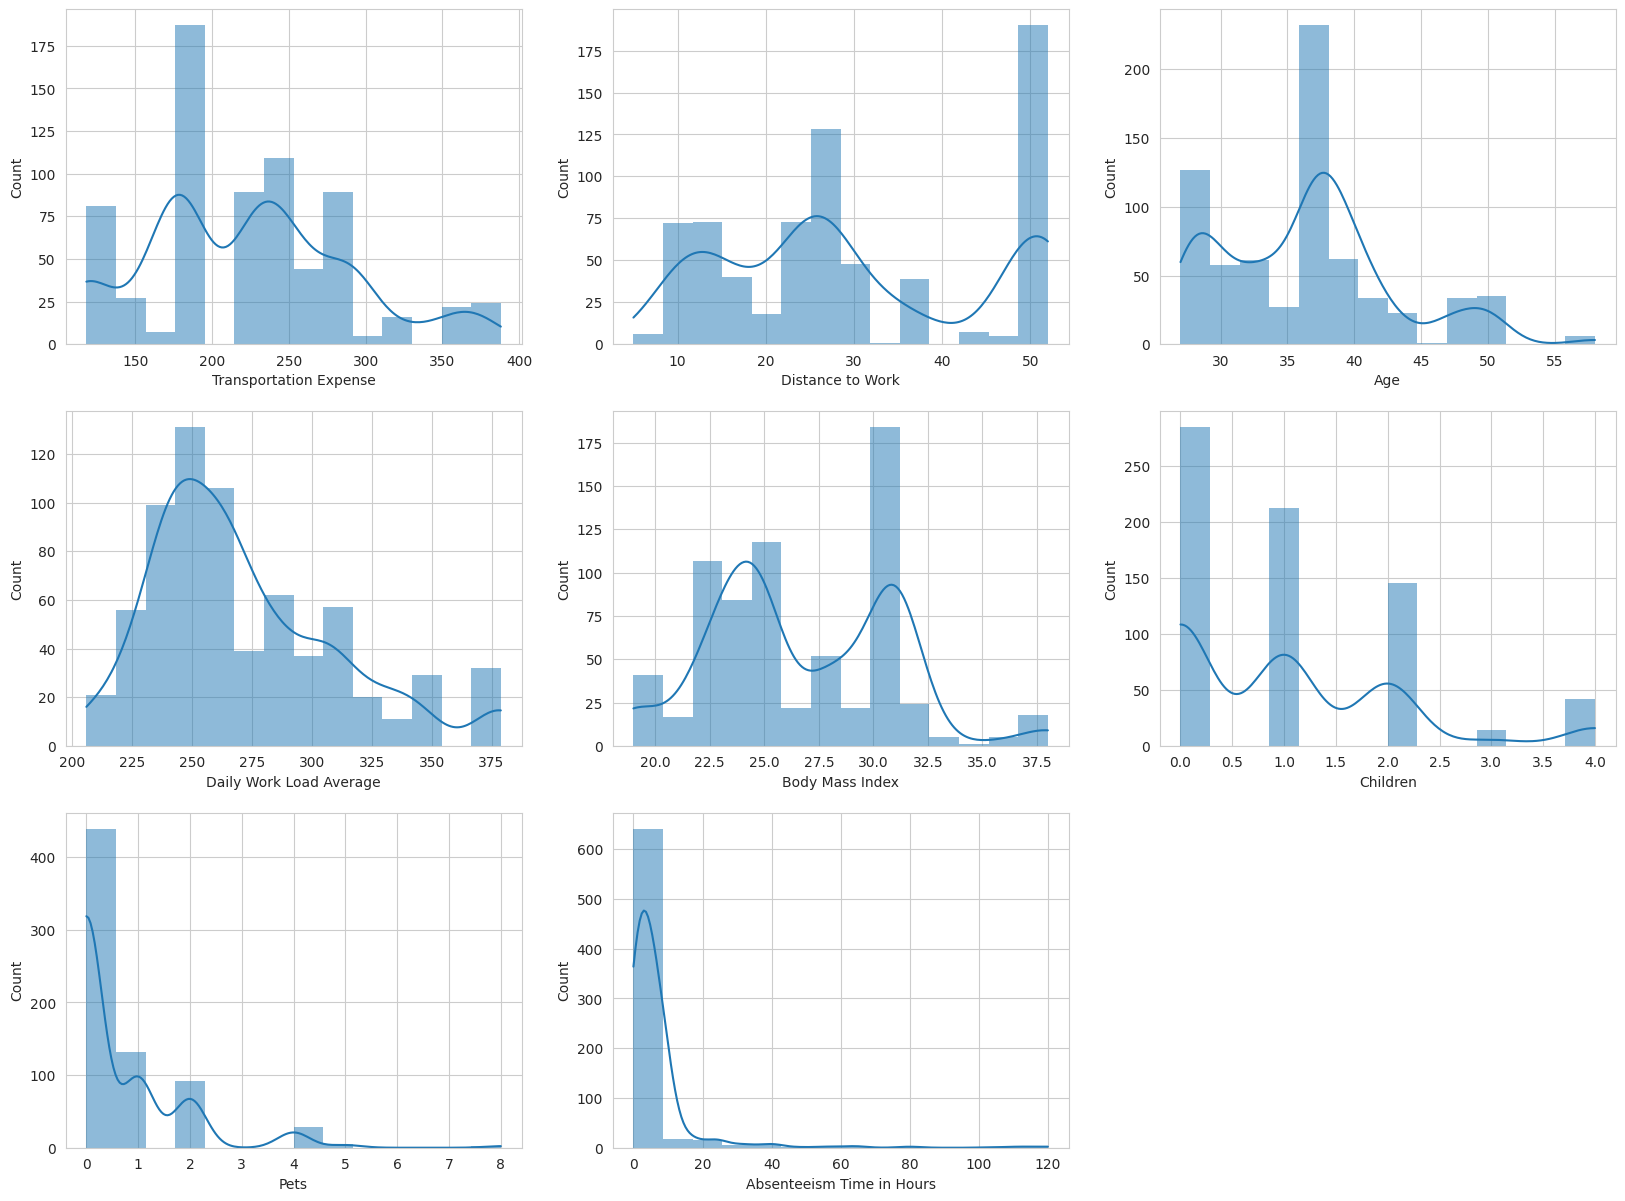

In [115]:
# graficamos la distribucion de las variables numericas
num_df = data[numerical_atts]
plt.figure(figsize=(20,20))
for i in range(1, 9):
    plt.subplot(4, 3, i)
    sns.histplot(num_df[num_df.columns[i-1]],bins=14, kde=True, linewidth=0)

<ipython-input-116-2f9de901a849>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=data, x='Reason for Absence', kind= 'count', height=4, aspect=4, palette='muted')


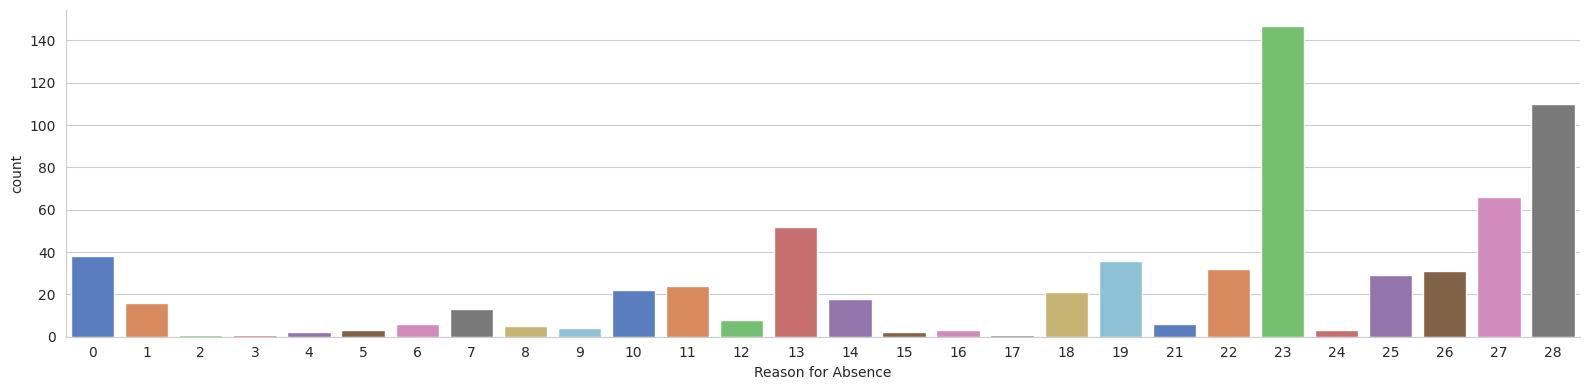

In [116]:
# graficamos como esta distribuida la variable "reason for absence"
sns.set_style("whitegrid")
sns.catplot(data=data, x='Reason for Absence', kind= 'count', height=4, aspect=4, palette='muted')

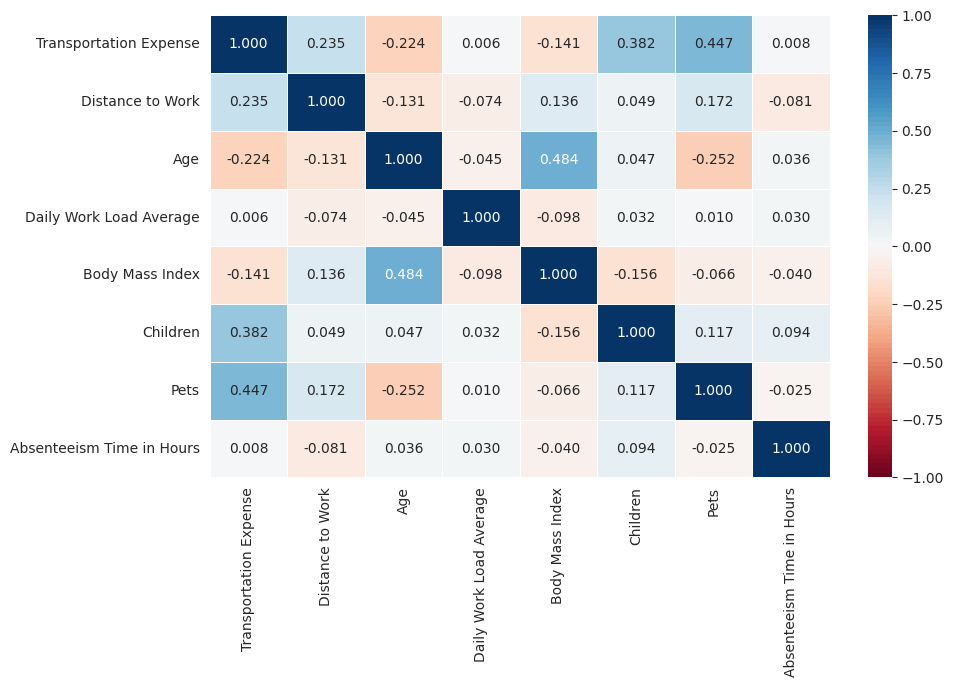

In [117]:
# creamos la matríz de correlación
num_corr = num_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_corr, annot=True, fmt=".3f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("RdBu", 100))
plt.yticks(rotation=0)
plt.show()

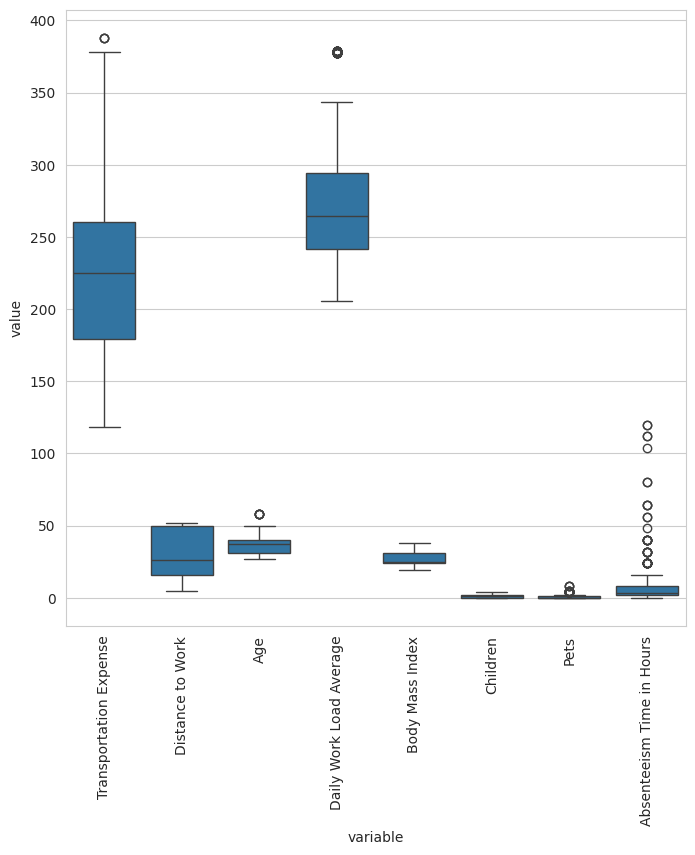

In [118]:
# Graficamos boxplots para resumir la distribución de datos cuantitativos, esto nos permite identificar rápidamente la mediana, los cuartiles, la asimetría y la presencia de valores atípicos en un conjunto de datos
plt.figure(figsize=(8,8))
sns.boxplot(x="variable", y="value", data=pd.melt(num_df))
plt.xticks(rotation=90)
plt.show()


# Preprocesamiento del dataset

In [119]:
data.head()

,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [120]:
data['Reason for Absence']

0      26
1       0
2      23
3       7
4      23
       ..
695    10
696     6
697    10
698    23
699    28
Name: Reason for Absence, Length: 700, dtype: int64

In [121]:
data['Reason for Absence'].unique()

array([26,  0, 23,  7, 22, 19,  1, 11, 14, 21, 10, 13, 28, 18, 25, 24,  6,
       27, 17,  8, 12,  5,  9, 15,  4,  3,  2, 16])

In [122]:
len(data['Reason for Absence'].unique())

28

In [123]:
#En Python, podemos convertir las variables categóricas en ficticias utilizando el método get_dummies de pandas:
reason_columns = pd.get_dummies(data['Reason for Absence'])

In [124]:
reason_columns

,0,1,2,3,4,5,6,7,8,9,...,18,19,21,22,23,24,25,26,27,28
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
696,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
697,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
698,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [125]:
reason_columns['check'] = reason_columns.sum(axis=1)

In [126]:
reason_columns

,0,1,2,3,4,5,6,7,8,9,...,19,21,22,23,24,25,26,27,28,check
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,1
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
696,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
697,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
698,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1


In [127]:
reason_columns['check'].unique()

array([1])

In [128]:
reason_columns = reason_columns.drop(['check'], axis = 1)

In [129]:
#El argumento de palabra clave drop_first devolverá P– 1 columnas. Lo utilizamos para evitar el problema de la multicolinealidad.
reason_columns = pd.get_dummies(data['Reason for Absence'], drop_first=True)

In [131]:
data.drop(['Reason for Absence'], axis=1, inplace=True)

In [132]:
#traer las que tienen 1 en las columnas de cada grupo
reason_columns.loc[:, 15:17].max(axis=1)

0      False
1      False
2      False
3      False
4      False
       ...  
695    False
696    False
697    False
698    False
699    False
Length: 700, dtype: bool

In [133]:
reason_type_1 = reason_columns.loc[:, 1:14].max(axis=1)
reason_type_2 = reason_columns.loc[:, 15:17].max(axis=1)
reason_type_3 = reason_columns.loc[:, 18:21].max(axis=1)
reason_type_4 = reason_columns.loc[:, 22:].max(axis=1)

In [134]:
#Concatenar razones con el dataframe
data = pd.concat([data, reason_type_1, reason_type_2, reason_type_3, reason_type_4], axis = 1)
data.head()

,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,0,1,2,3
0,07/07/2015,289,36,33,239.554,30,1,2,1,4,False,False,False,True
1,14/07/2015,118,13,50,239.554,31,1,1,0,0,False,False,False,False
2,15/07/2015,179,51,38,239.554,31,1,0,0,2,False,False,False,True
3,16/07/2015,279,5,39,239.554,24,1,2,0,4,True,False,False,False
4,23/07/2015,289,36,33,239.554,30,1,2,1,2,False,False,False,True


In [135]:
#Renombramos las columnas
data.columns.values

array(['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 0, 1, 2, 3],
      dtype=object)

In [136]:
nombres = ['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'Reason_1', 'Reason_2', 'Reason_3', 'Reason_4']

In [137]:
data.columns = nombres

In [138]:
data.columns.values

array(['Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours', 'Reason_1',
       'Reason_2', 'Reason_3', 'Reason_4'], dtype=object)

In [139]:
nombres_ordenados= ['Reason_1','Reason_2', 'Reason_3', 'Reason_4','Date', 'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours']

In [140]:
df = data[nombres_ordenados]

In [141]:
df.columns.values

array(['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Date',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education',
       'Children', 'Pets', 'Absenteeism Time in Hours'], dtype=object)

In [142]:
type(df.Date[0])

str

In [143]:
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y')

In [144]:
df.Date.head(20)

0    2015-07-07
1    2015-07-14
2    2015-07-15
3    2015-07-16
4    2015-07-23
5    2015-07-10
6    2015-07-17
7    2015-07-24
8    2015-07-06
9    2015-07-13
10   2015-07-20
11   2015-07-14
12   2015-07-15
13   2015-07-15
14   2015-07-15
15   2015-07-17
16   2015-07-17
17   2015-07-27
18   2015-07-30
19   2015-08-05
Name: Date, dtype: datetime64[ns]

In [145]:
df.Date[0]

Timestamp('2015-07-07 00:00:00')

In [146]:
df.Date[0].month

7

In [147]:
lista_meses = []
for i in range(len(df)):
    lista_meses.append(df.Date[i].month)

In [148]:
df['Month Value'] = lista_meses
df.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month Value
0,False,False,False,True,2015-07-07,289,36,33,239.554,30,1,2,1,4,7
1,False,False,False,False,2015-07-14,118,13,50,239.554,31,1,1,0,0,7
2,False,False,False,True,2015-07-15,179,51,38,239.554,31,1,0,0,2,7
3,True,False,False,False,2015-07-16,279,5,39,239.554,24,1,2,0,4,7
4,False,False,False,True,2015-07-23,289,36,33,239.554,30,1,2,1,2,7


In [149]:
#Extraer el dia de la semana
df.Date[0].weekday()

1

In [150]:
def dia_diasemana(data):
    return data.weekday()

In [151]:
df['Day of the Week'] = df.Date.apply(dia_diasemana)

In [152]:
df.columns

Index(['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4', 'Date',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
       'Pets', 'Absenteeism Time in Hours', 'Month Value', 'Day of the Week'],
      dtype='object')

In [153]:
df.Education.value_counts()

Education
1    583
3     73
2     40
4      4
Name: count, dtype: int64

In [154]:
df.Education = df.Education.map({
                            1:0,
                            2:1,
                            3:1,
                            4:1
                            })

In [155]:
df.Education.value_counts()

Education
0    583
1    117
Name: count, dtype: int64

In [156]:
df.to_csv(r'datasetpreprocesado.csv', index = False)

In [157]:
df_preprocesado = pd.read_csv('datasetpreprocesado.csv')
df_preprocesado.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month Value,Day of the Week
0,False,False,False,True,2015-07-07,289,36,33,239.554,30,0,2,1,4,7,1
1,False,False,False,False,2015-07-14,118,13,50,239.554,31,0,1,0,0,7,1
2,False,False,False,True,2015-07-15,179,51,38,239.554,31,0,0,0,2,7,2
3,True,False,False,False,2015-07-16,279,5,39,239.554,24,0,2,0,4,7,3
4,False,False,False,True,2015-07-23,289,36,33,239.554,30,0,2,1,2,7,3


# Modelo de Machine Learning

Se probará un modelo de regresión logística para clasificar a las personas en 2 clases:
* personas con excesiva ausencia laboral
* personas con moderada ausencia laboral.

La media de las horas de ausencia laboral es 3. Se plantea la siguiente hipótesis: ¿Cómo definimos las clases? Moderada ausencia si las horas son menores o iguales a 3 y excesivas si son mayores a 4 horas.

Lo que se hace ahora es cambiar las horas 1,2,3 por la clase 0 (Moderada) y 4,5,6,7,8… por la clase 1 (Excesivo). Para esto se usara la función where de python.

In [158]:
df_preprocesado['Absenteeism Time in Hours'].median()

3.0

In [159]:
#devuelve 1 si consigue horas 3 mayores a 3 y 0 si no cumple con esto, es decir, menores o iguales a 3
targets = np.where(df_preprocesado['Absenteeism Time in Hours']>3, 1, 0)
targets

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,

In [160]:
df_preprocesado['Excessive Absenteeism'] = targets
df_preprocesado.head()

,Reason_1,Reason_2,Reason_3,Reason_4,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours,Month Value,Day of the Week,Excessive Absenteeism
0,False,False,False,True,2015-07-07,289,36,33,239.554,30,0,2,1,4,7,1,1
1,False,False,False,False,2015-07-14,118,13,50,239.554,31,0,1,0,0,7,1,0
2,False,False,False,True,2015-07-15,179,51,38,239.554,31,0,0,0,2,7,2,0
3,True,False,False,False,2015-07-16,279,5,39,239.554,24,0,2,0,4,7,3,1
4,False,False,False,True,2015-07-23,289,36,33,239.554,30,0,2,1,2,7,3,0


In [161]:
# “se recomienda un balance para 2 clases del 50 % de datos entre estas. En
# este caso un 60/40 % funcionaría bien para el algoritmo de regresión
# logística"

print('Porcentaje total de personas con excesiva ausencia laboral',targets.sum()*100 / targets.shape[0])
print('Porcentaje total de personas con moderada ausencia laboral',100 - targets.sum()*100 / targets.shape[0])

Porcentaje total de personas con excesiva ausencia laboral 45.57142857142857
Porcentaje total de personas con moderada ausencia laboral 54.42857142857143


In [162]:
targets.shape

(700,)

In [163]:
df_preprocesado.drop(['Absenteeism Time in Hours'], axis=1, inplace=True)

df_preprocesado.drop(['Date'], axis=1, inplace=True)

df_preprocesado.shape



(700, 15)

In [164]:
df_preprocesado.columns

Index(['Reason_1', 'Reason_2', 'Reason_3', 'Reason_4',
       'Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
       'Pets', 'Month Value', 'Day of the Week', 'Excessive Absenteeism'],
      dtype='object')

In [165]:
#Seleccionar las inputs del modelo
inputs = df_preprocesado.iloc[:,:-1]

In [166]:
#Standarizacion de la data
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
data_escalada = StandardScaler()

In [167]:
data_escalada.fit(inputs)

StandardScaler()

In [168]:
escalada_inputs = data_escalada.transform(inputs)

In [169]:
class CustomScaler(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None, copy=True, with_mean=True, with_std=True):
        self.scaler = StandardScaler(copy=copy, with_mean=with_mean, with_std=with_std)
        self.columns = columns
        self.mean_ = None
        self.var_ = None

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        self.mean_ = np.mean(X[self.columns])
        self.var_ = np.var(X[self.columns])
        return self

    def transform(self, X, y=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns)
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [170]:
columnas_a_escalar = ['Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Education', 'Children',
       'Pets', 'Month Value', 'Day of the Week']

In [171]:
# Crear una instancia de CustomScaler
escalado = CustomScaler(columns=columnas_a_escalar)

# Ajustar el escalado a tus datos
escalado.fit(inputs)

# Transformar tus datos
escalada_inputs = escalado.transform(inputs)

In [172]:
escalada_inputs

,Reason_1,Reason_2,Reason_3,Reason_4,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Month Value,Day of the Week
0,False,False,False,True,1.005844,0.412816,-0.536062,-0.806331,0.767431,-0.447980,0.880469,0.268487,0.182726,-0.683704
1,False,False,False,False,-1.574681,-1.141882,2.130803,-0.806331,1.002633,-0.447980,-0.019280,-0.589690,0.182726,-0.683704
2,False,False,False,True,-0.654143,1.426749,0.248310,-0.806331,1.002633,-0.447980,-0.919030,-0.589690,0.182726,-0.007725
3,True,False,False,False,0.854936,-1.682647,0.405184,-0.806331,-0.643782,-0.447980,0.880469,-0.589690,0.182726,0.668253
4,False,False,False,True,1.005844,0.412816,-0.536062,-0.806331,0.767431,-0.447980,0.880469,0.268487,0.182726,0.668253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,True,False,False,False,-0.654143,-0.533522,0.562059,-0.853789,-1.114186,2.232242,0.880469,-0.589690,-0.388293,-0.007725
696,True,False,False,False,0.040034,-0.263140,-1.320435,-0.853789,-0.643782,-0.447980,-0.019280,1.126663,-0.388293,-0.007725
697,True,False,False,False,1.624567,-0.939096,-1.320435,-0.853789,-0.408580,2.232242,-0.919030,-0.589690,-0.388293,0.668253
698,False,False,False,True,0.190942,-0.939096,-0.692937,-0.853789,-0.408580,2.232242,-0.919030,-0.589690,-0.388293,0.668253


In [173]:
from sklearn.model_selection import train_test_split
train_test_split(escalada_inputs, targets )

[     Reason_1  Reason_2  Reason_3  Reason_4  Transportation Expense  \
 282     False     False     False      True                0.568211   
 668     False      True     False     False                0.190942   
 337     False     False     False     False                0.854936   
 348     False     False     False      True               -0.654143   
 670     False     False     False      True               -1.016322   
 ..        ...       ...       ...       ...                     ...   
 411     False     False     False      True                0.356940   
 60      False     False     False      True               -0.654143   
 173      True     False     False     False               -0.654143   
 564     False     False      True     False                0.160760   
 277     False     False     False     False                1.036026   
 
      Distance to Work       Age  Daily Work Load Average  Body Mass Index  \
 282          1.359154 -0.065439                 0.56047

In [174]:
X_train, X_test, y_train, y_test = train_test_split(escalada_inputs, targets, test_size=0.20)


In [175]:
print(X_train.shape, y_train.shape)

(560, 14) (560,)


In [176]:
print(X_test.shape, y_test.shape)

(140, 14) (140,)


# Modelo de Regresión Logistica

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [178]:
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression()

In [179]:
reg.score(X_train, y_train)

0.7714285714285715

In [180]:
reg.score(X_test, y_test)

0.7642857142857142

In [181]:
#Guardar Modelo
import pickle
with open('model', 'wb') as file:
    pickle.dump(reg,file)

In [182]:
salida = reg.predict(X_train)

In [183]:
salida

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [184]:
salida == y_train

array([ True,  True, False,  True,  True,  True, False,  True, False,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,

In [185]:
np.sum(salida==y_train)/salida.shape[0]

0.7714285714285715

In [186]:
#Calculando coefiecientes e interseccion
reg.intercept_

array([-1.66303089])

In [187]:
reg.coef_

array([[ 2.74161885,  0.65121574,  2.95142135,  0.94241366,  0.61287662,
         0.01490627, -0.17095496,  0.00376671,  0.23458944,  0.02841559,
         0.38638828, -0.34432549,  0.07305004, -0.21934319]])

In [188]:
feature_name = inputs.columns.values

In [189]:


summary_table = pd.DataFrame(columns=['Caracteristica'], data = feature_name)
summary_table['Coeficiente'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Interseccion', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table['Odds_ratio'] = np.exp(summary_table.Coeficiente)
summary_table



,Caracteristica,Coeficiente,Odds_ratio
0,Interseccion,-1.663031,0.189564
1,Reason_1,2.741619,15.512077
2,Reason_2,0.651216,1.917871
3,Reason_3,2.951421,19.133129
4,Reason_4,0.942414,2.566168
5,Transportation Expense,0.612877,1.845733
6,Distance to Work,0.014906,1.015018
7,Age,-0.170955,0.842860
8,Daily Work Load Average,0.003767,1.003774
9,Body Mass Index,0.234589,1.264390


El entrenamiento y la puntuación de un modelo de regresión logística proporcionan una comprensión vital sobre la importancia de cada característica en la predicción del resultado. Los coeficientes más grandes indican una mayor influencia de esa característica en el resultado. Por otro lado, los coeficientes más pequeños indican una influencia menor.

En nuestro caso, las características están estandarizadas, lo que significa que tienen la misma escala, lo que nos permite comparar su importancia directamente. Cuando aplicamos la regresión logística, obtenemos el logaritmo de las odds (oportunidades) como resultado. La transformación logarítmica nos permite clasificar el resultado en 0 o 1.

El valor de odds_ratio proporciona una perspectiva importante: por ejemplo, para la razón 3, que tiene un odds_ratio mayor, indica que una persona con esta razón tiene aproximadamente 18 veces más probabilidades de estar excesivamente ausente que una persona que no presenta esta razón. Este análisis resume de manera efectiva cómo cada característica afecta las probabilidades de que ocurra el evento de interés.

In [190]:
summary_table.sort_values('Odds_ratio', ascending=False)

,Caracteristica,Coeficiente,Odds_ratio
3,Reason_3,2.951421,19.133129
1,Reason_1,2.741619,15.512077
4,Reason_4,0.942414,2.566168
2,Reason_2,0.651216,1.917871
5,Transportation Expense,0.612877,1.845733
11,Children,0.386388,1.471656
9,Body Mass Index,0.234589,1.264390
13,Month Value,0.073050,1.075784
10,Education,0.028416,1.028823
6,Distance to Work,0.014906,1.015018


Se puede concluir que la razón con el mayor coeficiente y, por ende, el mayor impacto en la ausencia laboral es la Razón 3, que abarca síntomas graves poco comunes y envenenamiento. Este resultado tiene sentido, ya que es comprensible que alguien no asista al trabajo de inmediato en tales circunstancias.

La segunda razón con mayor impacto es la Razón 1, relacionada con problemas circulatorios, respiratorios, digestivos, entre otros. Es comprensible que alguien falte al trabajo debido a malestares estomacales, dolor abdominal, náuseas, etc. Una persona con esta razón tiene aproximadamente 14 veces más probabilidades de ausentarse excesivamente que alguien sin esta razón.

La Razón 2 está relacionada con embarazo y fiestas de cumpleaños. Es lógico que esta razón tenga una baja probabilidad de ausencia excesiva, ya que los días de licencia por embarazo suelen ser limitados, y las fiestas de cumpleaños de los hijos no ocupan mucho tiempo en el año.

El costo del transporte es la variable más relevante entre las no categóricas, aunque al estar estandarizada, su interpretación directa en términos de odds es limitada.

Los modelos estandarizados son preferidos por ingenieros en machine learning cuando se busca una alta precisión, ya que el algoritmo tiende a funcionar mejor con datos estandarizados. Sin embargo, los economistas y estadistas suelen priorizar la interpretación de variables sobre la precisión. Los científicos de datos se encuentran en un punto intermedio, ya que a veces necesitan alta precisión y otras veces valoran otras consideraciones.







# Guardar el Modelo y Deploy

In [191]:
import pickle

#Guardando el modelo
with open('model', 'wb') as file:
    pickle.dump(reg, file)

#Guardando la data estandarizada
with open('scaler', 'wb') as file:
    pickle.dump(escalado, file)
